# Credit Card Risk Assessment Using Ensemble Learning Models

### Import Required Libraries

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

# Import specific classes and functions from scikit-learn
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, RobustScaler, MinMaxScaler, OrdinalEncoder
from sklearn.compose import ColumnTransformer

# Import various classifiers from scikit-learn, CatBoost, and XGBoost
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, VotingClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier, plot_importance

# Import various metrics and tools for model evaluation and selection
from sklearn.metrics import classification_report, f1_score, confusion_matrix, ConfusionMatrixDisplay, accuracy_score, recall_score, precision_recall_curve
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, StratifiedKFold

# Import set_config from scikit-learn to configure display options
from sklearn import set_config

# Ignore warnings to ensure clean output
import warnings
warnings.filterwarnings('ignore')

# Set the display configuration for scikit-learn
set_config(display='diagram')

### Load the Dataset

In [2]:
credit_risk = pd.read_csv('Datasets/credit_risk_dataset.csv')
credit_risk

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,1,0.59,Y,3
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,N,2
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,N,3
3,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,1,0.53,N,2
4,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,1,0.55,Y,4
...,...,...,...,...,...,...,...,...,...,...,...,...
32576,57,53000,MORTGAGE,1.0,PERSONAL,C,5800,13.16,0,0.11,N,30
32577,54,120000,MORTGAGE,4.0,PERSONAL,A,17625,7.49,0,0.15,N,19
32578,65,76000,RENT,3.0,HOMEIMPROVEMENT,B,35000,10.99,1,0.46,N,28
32579,56,150000,MORTGAGE,5.0,PERSONAL,B,15000,11.48,0,0.10,N,26


In [3]:
credit_risk.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32581 entries, 0 to 32580
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  32581 non-null  int64  
 1   person_income               32581 non-null  int64  
 2   person_home_ownership       32581 non-null  object 
 3   person_emp_length           31686 non-null  float64
 4   loan_intent                 32581 non-null  object 
 5   loan_grade                  32581 non-null  object 
 6   loan_amnt                   32581 non-null  int64  
 7   loan_int_rate               29465 non-null  float64
 8   loan_status                 32581 non-null  int64  
 9   loan_percent_income         32581 non-null  float64
 10  cb_person_default_on_file   32581 non-null  object 
 11  cb_person_cred_hist_length  32581 non-null  int64  
dtypes: float64(3), int64(5), object(4)
memory usage: 3.0+ MB


In [4]:
credit_risk.shape

(32581, 12)

The problem consists of predicting a label for each loan/person. The target column, 'loan_status,' provides a binary classification for the loan status (0 if not in default, 1 if in default). The 11 features can be split into seven numerical and four categorical features, which must be processed separately. Below, we can explore the statistics of the numerical features plus the target.

In [5]:
credit_risk.describe().round(2)

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_cred_hist_length
count,32581.00,32581.00,31686.00,32581.00,29465.00,32581.00,32581.00,32581.00
mean,27.73,66074.85,4.79,9589.37,11.01,0.22,0.17,5.80
std,6.35,61983.12,4.14,6322.09,3.24,0.41,0.11,4.06
min,20.00,4000.00,0.00,500.00,5.42,0.00,0.00,2.00
25%,23.00,38500.00,2.00,5000.00,7.90,0.00,0.09,3.00
50%,26.00,55000.00,4.00,8000.00,10.99,0.00,0.15,4.00
75%,30.00,79200.00,7.00,12200.00,13.47,0.00,0.23,8.00
max,144.00,6000000.00,123.00,35000.00,23.22,1.00,0.83,30.00


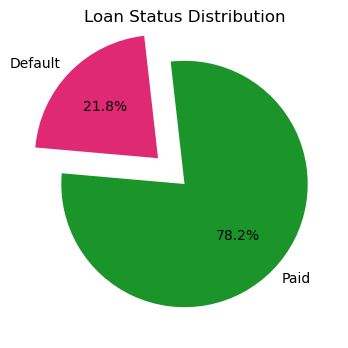

In [6]:
plt.figure(figsize=(10, 4))

# Define custom colors for non-default and default
non_default_color = '#1B952A'
default_color = '#DF2973'

# Custom colors for pie chart
custom_palette = [non_default_color, default_color]

loan_status_counts = credit_risk['loan_status'].value_counts()

labels = ['Paid', 'Default']
sizes = loan_status_counts.values

plt.pie(sizes, labels=labels, autopct='%1.1f%%', explode=[0, 0.3], startangle=175, colors=custom_palette)
plt.title('Loan Status Distribution')
plt.show()

An initial observation is that the dataset requires class balance. The target population is divided, with 78.2% in class 0 (non-default) and 21.8% in class 1 (default).

Our next step is to plot each feature individually to demonstrate if there is any correlation with the target.

### Exploratory Data Analysis

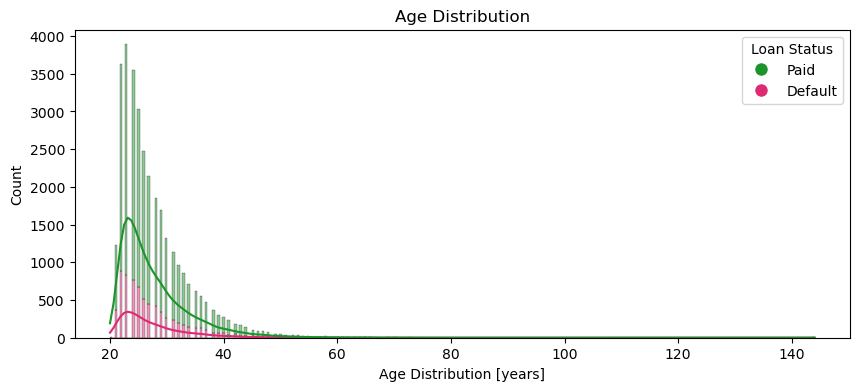

In [7]:
plt.figure(figsize=(10, 4))

sns.histplot(data=credit_risk, x='person_age', hue='loan_status', multiple='stack', kde=True, hue_order=[0, 1], palette=[non_default_color, default_color])
plt.title('Age Distribution')
plt.xlabel('Age Distribution [years]')
plt.ylabel('Count')

# Create a custom legend with specified colors and labels
legend_labels = ['Paid', 'Default']
legend_colors = [non_default_color, default_color]
plt.legend(legend_labels, title='Loan Status', loc='upper right', labels=legend_labels, handles=[plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10) for color in legend_colors])

plt.show()

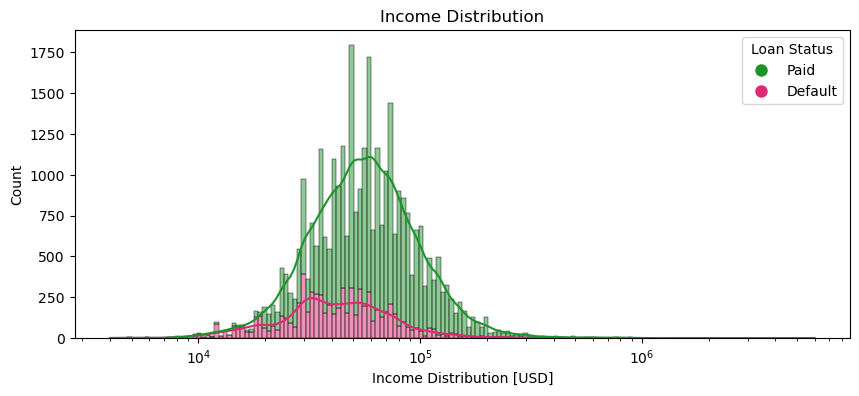

In [8]:
plt.figure(figsize=(10, 4))
#Plot Income Distribution
sns.histplot(data=credit_risk, x='person_income', hue='loan_status', multiple='stack', log_scale=True, kde=True, hue_order=[0, 1], palette=[non_default_color, default_color])
plt.title('Income Distribution')
plt.xlabel('Income Distribution [USD]')
plt.ylabel('Count')
plt.legend(legend_labels, title='Loan Status', loc='upper right', labels=legend_labels, handles=[plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10) for color in legend_colors])
plt.show()

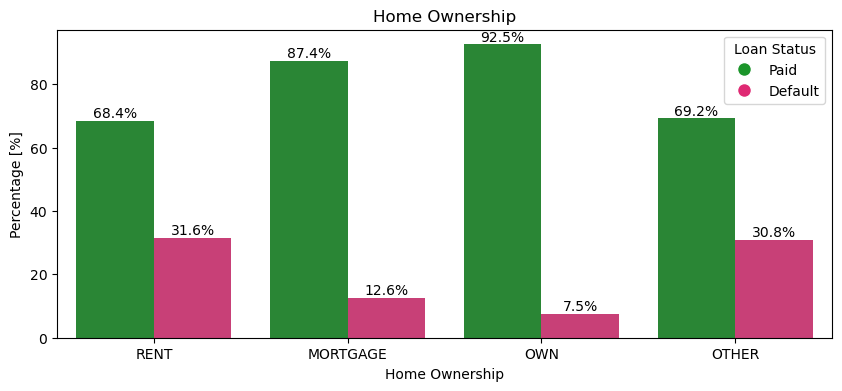

In [9]:
plt.figure(figsize=(10, 4))

# Calculate the percentage for each group
home_percentage = credit_risk.groupby(['person_home_ownership', 'loan_status']).size() / credit_risk.groupby(['person_home_ownership']).size() * 100
home_percentage = home_percentage.reset_index(name='percentage')
home_order      = credit_risk['person_home_ownership'].value_counts().sort_values(ascending=False).index

sns.barplot(x='person_home_ownership', y='percentage', hue='loan_status', data=home_percentage, order=home_order,
            palette=[non_default_color, default_color])
plt.title('Home Ownership')
plt.xlabel('Home Ownership')
plt.ylabel('Percentage [%]')

plt.legend(legend_labels, title='Loan Status', loc='upper right', labels=legend_labels, handles=[
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10) for color in legend_colors])

# Add percentage labels to the bars
ax = plt.gca()
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2., height + 1, f'{height:.1f}%', ha='center')

plt.show()

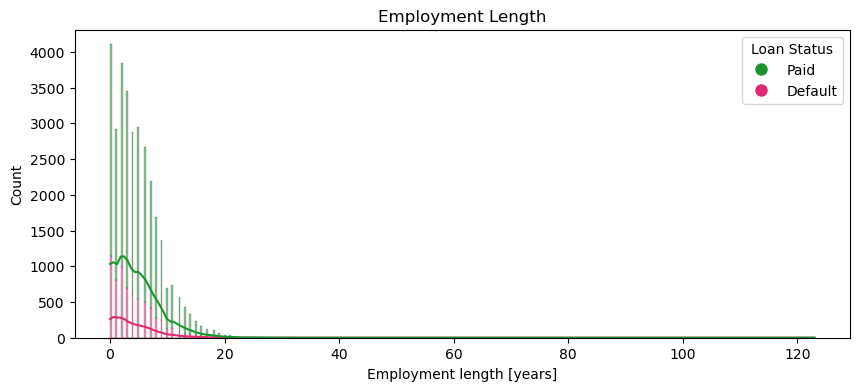

In [10]:
#Plot Employment Length
plt.figure(figsize = (10, 4))
sns.histplot(data=credit_risk, x='person_emp_length', hue='loan_status', multiple='stack', kde=True, hue_order=[0, 1], palette=[non_default_color, default_color])
plt.title('Employment Length')
plt.xlabel('Employment length [years]')
plt.ylabel('Count')
plt.legend(legend_labels, title='Loan Status', loc='upper right', labels=legend_labels, handles=[plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10) for color in legend_colors])

plt.show()

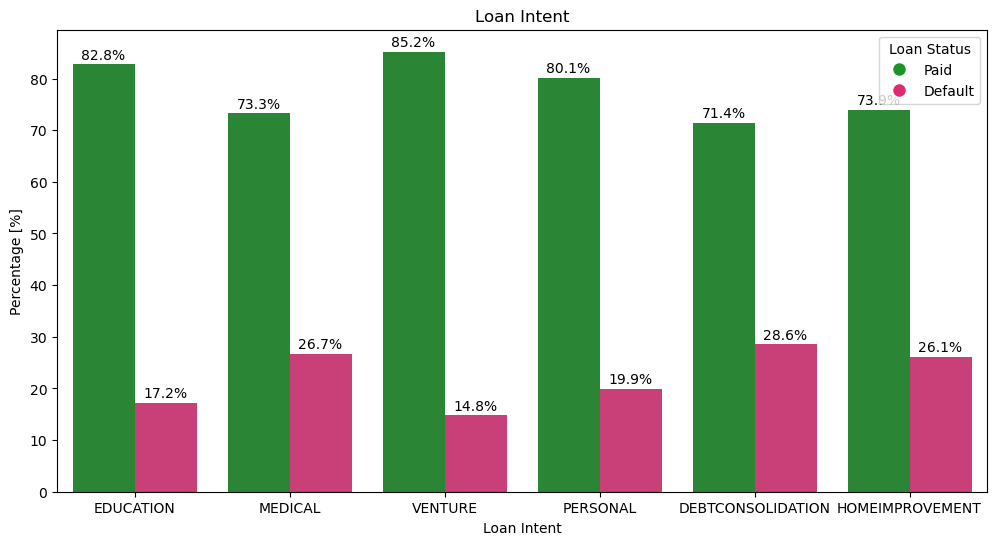

In [11]:
plt.figure(figsize=(12, 6))

# Calculate the percentage for each group
intent_percentage = credit_risk.groupby(['loan_intent', 'loan_status']).size() / credit_risk.groupby(['loan_intent']).size() * 100
intent_percentage = intent_percentage.reset_index(name='percentage')
intent_order      = credit_risk['loan_intent'].value_counts().sort_values(ascending=False).index

sns.barplot(x='loan_intent', y='percentage', hue='loan_status', data=intent_percentage, order=intent_order,
            palette=[non_default_color, default_color])
plt.title('Loan Intent')
plt.xlabel('Loan Intent')
plt.ylabel('Percentage [%]')

# Create a custom legend with specified colors and labels
plt.legend(legend_labels, title='Loan Status', loc='upper right', labels=legend_labels, handles=[
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10) for color in legend_colors])

# Add percentage labels to the bars
ax = plt.gca()
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2., height + 1, f'{height:.1f}%', ha='center')

plt.show()

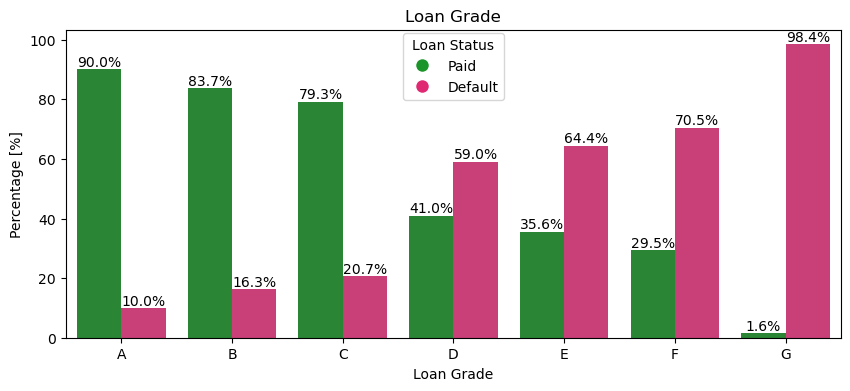

In [12]:
plt.figure(figsize=(10, 4))

# Calculate the percentage for each group
grade_percentage = credit_risk.groupby(['loan_grade', 'loan_status']).size() / credit_risk.groupby(['loan_grade']).size() * 100
grade_percentage = grade_percentage.reset_index(name='percentage')
grade_order      = credit_risk['loan_grade'].value_counts().sort_values(ascending=False).index

sns.barplot(x='loan_grade', y='percentage', hue='loan_status', data=grade_percentage, order=grade_order,
            palette=[non_default_color, default_color])
plt.title('Loan Grade')
plt.xlabel('Loan Grade')
plt.ylabel('Percentage [%]')

# Create a custom legend with specified colors and labels and place it in the middle
plt.legend(legend_labels, title='Loan Status', loc='lower center', bbox_to_anchor=(0.5, 0.75),
           labels=legend_labels, handles=[plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10) for color in legend_colors])

# Add percentage labels to the bars
ax = plt.gca()
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2., height + 1, f'{height:.1f}%', ha='center')

plt.show()

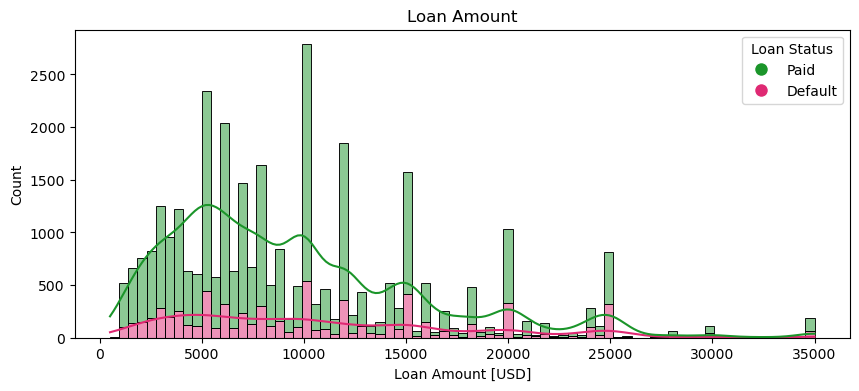

In [13]:
#Plot Loan Amount
plt.figure(figsize = (10,4))
sns.histplot(data = credit_risk, x = 'loan_amnt', hue = 'loan_status', multiple = 'stack', kde = True, hue_order=[0, 1], palette=[non_default_color, default_color])
plt.title('Loan Amount')
plt.xlabel('Loan Amount [USD]')
plt.ylabel('Count')
plt.legend(legend_labels, title='Loan Status', loc='upper right', labels=legend_labels, handles=[ plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10) for color in legend_colors])

plt.show()

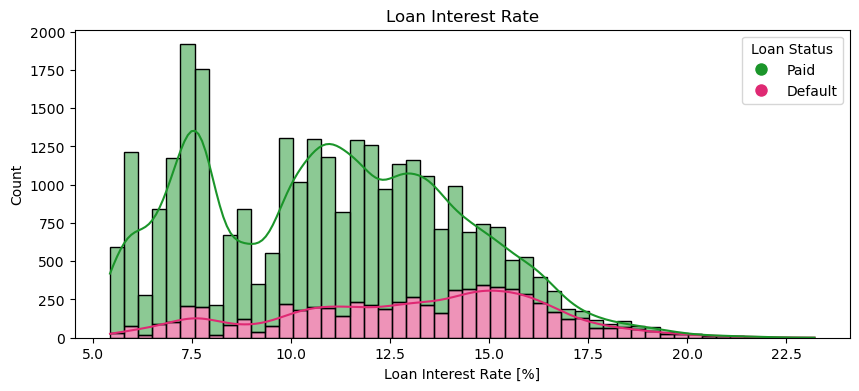

In [14]:
#Plot Loan Amount
plt.figure(figsize = (10,4))
sns.histplot(data = credit_risk, x = 'loan_int_rate', hue = 'loan_status', multiple = 'stack', kde = True, hue_order=[0, 1], palette=[non_default_color, default_color])
plt.title('Loan Interest Rate')
plt.xlabel('Loan Interest Rate [%]')
plt.ylabel('Count')
plt.legend(legend_labels, title='Loan Status', loc='upper right', labels=legend_labels, handles=[ plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10) for color in legend_colors])

plt.show()

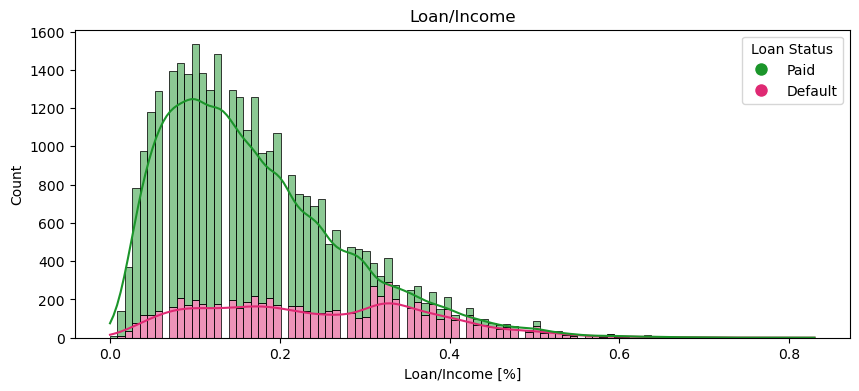

In [15]:
plt.figure(figsize = (10,4))
sns.histplot(data = credit_risk, x = 'loan_percent_income', hue = 'loan_status', multiple = 'stack', kde = True, hue_order=[0, 1], palette=[non_default_color, default_color])
plt.title('Loan/Income')
plt.xlabel('Loan/Income [%]')
plt.ylabel('Count')
plt.legend(legend_labels, title='Loan Status', loc='upper right', labels=legend_labels, handles=[ plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10) for color in legend_colors])

plt.show()

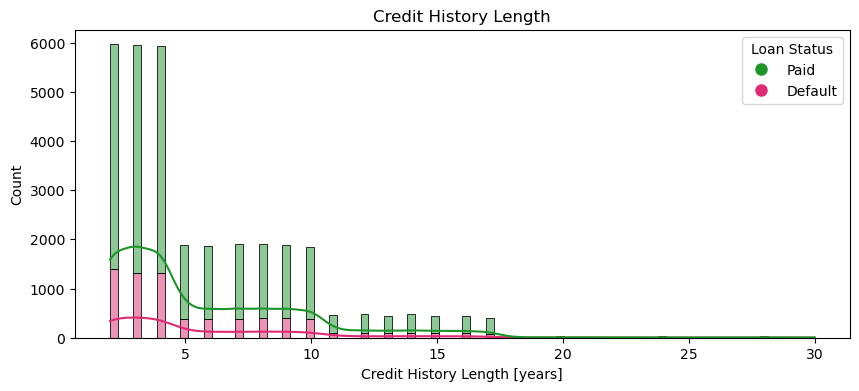

In [16]:
plt.figure(figsize = (10,4))
sns.histplot(data = credit_risk, x = 'cb_person_cred_hist_length', hue = 'loan_status', multiple = 'stack', kde = True, hue_order=[0, 1], palette=[non_default_color, default_color])
plt.title('Credit History Length')
plt.xlabel('Credit History Length [years]')
plt.ylabel('Count')
plt.legend(legend_labels, title='Loan Status', loc='upper right', labels=legend_labels, handles=[ plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10) for color in legend_colors])

plt.show()

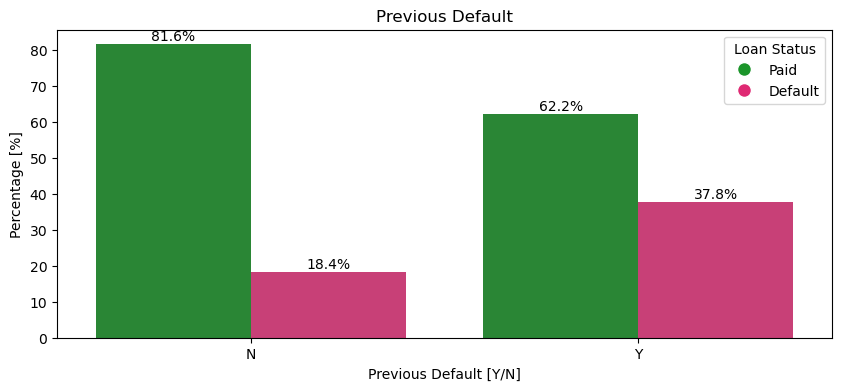

In [17]:
plt.figure(figsize=(10, 4))

# Calculate the percentage for each group
default_percentage = credit_risk.groupby(['cb_person_default_on_file', 'loan_status']).size() / credit_risk.groupby(['cb_person_default_on_file']).size() * 100
default_percentage = default_percentage.reset_index(name='percentage')
default_order      = credit_risk['cb_person_default_on_file'].value_counts().sort_values(ascending=False).index

sns.barplot(x='cb_person_default_on_file', y='percentage', hue='loan_status', data=default_percentage, order=default_order,
            palette=[non_default_color, default_color])
plt.title('Previous Default')
plt.xlabel('Previous Default [Y/N]')
plt.ylabel('Percentage [%]')

# Create a custom legend with specified colors and labels
plt.legend(legend_labels, title='Loan Status', loc='upper right', labels=legend_labels, 
           handles=[plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10) for color in legend_colors])

# Add percentage labels to the bars
ax = plt.gca()
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2., height + 1, f'{height:.1f}%', ha='center')

plt.show()

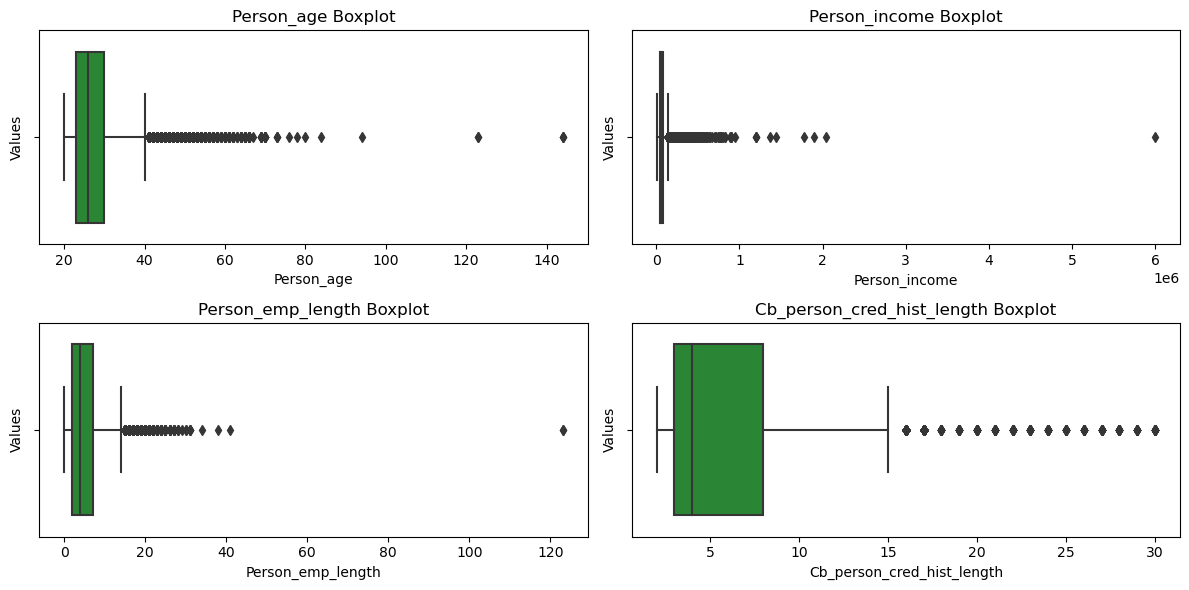

In [19]:
plt.figure(figsize=(12, 6))

# List of features to create boxplots for
features_to_plot = ['person_age', 'person_income', 'person_emp_length', 'cb_person_cred_hist_length']

# Create a custom palette for all features
custom_palette = [non_default_color, default_color]

# Create boxplots for each feature using the same palette
for i, feature in enumerate(features_to_plot, start=1):
    plt.subplot(2, 2, i)
    sns.boxplot(x=credit_risk[feature], palette=custom_palette)
    plt.title(f'{feature.capitalize()} Boxplot')
    plt.xlabel(feature.capitalize())
    plt.ylabel('Values')

plt.tight_layout()
plt.show()

### Data Preprocessing

#### 1. Data cleaning 

In [20]:
credit_risk.isna().sum()

person_age                       0
person_income                    0
person_home_ownership            0
person_emp_length              895
loan_intent                      0
loan_grade                       0
loan_amnt                        0
loan_int_rate                 3116
loan_status                      0
loan_percent_income              0
cb_person_default_on_file        0
cb_person_cred_hist_length       0
dtype: int64

In [ ]:
#Count Duplicate rows
credit_risk.duplicated().sum()

In [22]:
### Drop Duplicate rows
credit_risk = credit_risk.drop_duplicates()

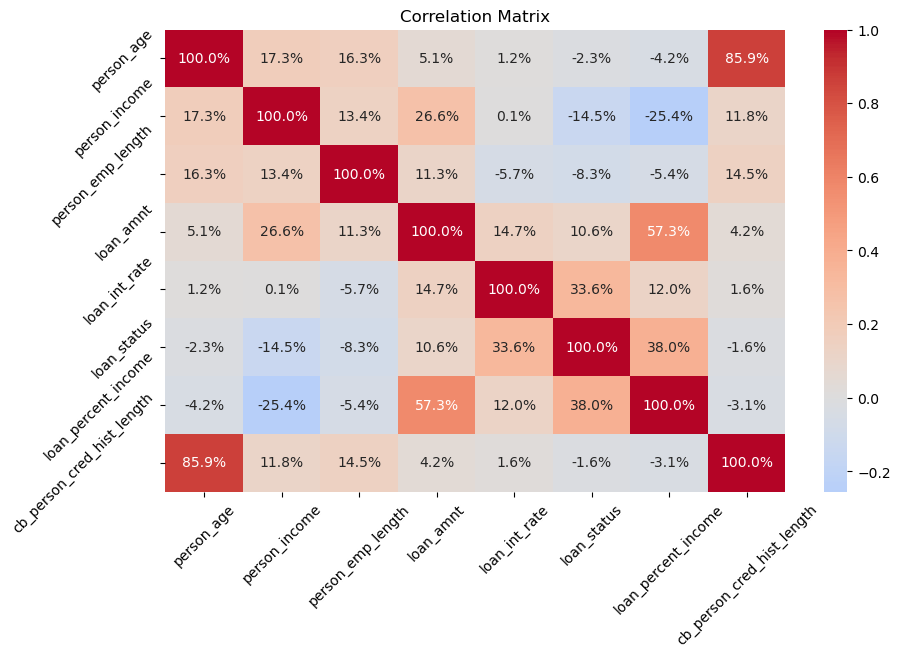

In [27]:
plt.figure(figsize=(10, 6))

# Calculate the correlation matrix
correlation_matrix = credit_risk.corr()

# Create a heatmap with correlation values displayed as percentages
sns.heatmap(correlation_matrix, annot=True, fmt=".1%", cmap='coolwarm', center=0, xticklabels=True, yticklabels=True, annot_kws={"size": 10})
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.title('Correlation Matrix')
plt.show()

With a value of 0.86, it is clear that there is a strong correlation between cb_person_cred_hist_length and person_age. It is evident from the linear correlation depicted in the plot below. Therefore, we have decided to eliminate cb_person_cred_hist_length from the dataset.

In [28]:
### Drop Credit History Length feature (cb_person_cred_hist_length)

credit_risk = credit_risk.drop(['cb_person_cred_hist_length'], axis=1) 

In [34]:
### Determine Person's whoes age above 122 years

credit_risk.loc[credit_risk['person_age'] > 122] 

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file


While conducting our EDA analysis, we encountered some highly concerning outliers in the data about the age of individuals. We have discovered that five people within the dataset possess an age that exceeds the officially recorded maximum age of 122 years. In light of this, we have decided to immediately remove these samples from the dataset to ensure the integrity and accuracy of our findings.

In [33]:
### Drop Person's whoes age above 122 years

credit_risk = credit_risk[credit_risk['person_age'] <= 122]

In [37]:
### Determine Employer Length above 122 years

credit_risk.loc[credit_risk['person_emp_length'] > 122] 

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file


The EDA analysis indicates the presence of outliers in person_emp_length for individuals above the age of 122 years. We must remove these outliers by excluding any individuals with an age above 122 years. It is a necessary step in ensuring the accuracy and reliability of our data.

In [36]:
### Drop Person employer length above 122 years

credit_risk = credit_risk[credit_risk['person_emp_length'] <= 122]

#### 2. Data Scalling Pipelines

We separated features and target variables and created pipelines for each feature type. For ordinal categorical features, we used an ordinal encoder and MinMaxScaler; for nominal categorical features, a One Hot Encoder, and for numerical features, a simpler imputer and robust scaler. We combined these pipelines with ColumnTransformer() and split the dataset into train and test sets, ensuring balanced subsets with equal target class ratios.

In [38]:
### Extract Features

features = credit_risk.drop('loan_status', axis=1).reset_index(drop=True) 

### Extract Target
target = credit_risk['loan_status'].reset_index(drop=True) 

In [39]:
### Pipeline definition
categorical_Ordinal = Pipeline( steps = [("oe",
                                         OrdinalEncoder()),
                                        ("mmscale", MinMaxScaler())])

categorical_Nominal = Pipeline( steps = [("ohe", OneHotEncoder())])

numerical_Pipeline  = Pipeline( steps = [("impute",
                                          SimpleImputer(strategy="mean"))
                                         ,("scale", RobustScaler())])

In [41]:
### Select ordinal columns

ordinal_Column = ['loan_grade']

### Select categorical columns
categorical_Columns = ['person_home_ownership', 'loan_intent', 'cb_person_default_on_file'] 

### Select numerical columns
numerical_Columns = ['person_age', 'person_income', 'person_emp_length', 'loan_amnt', 'loan_int_rate', 'loan_percent_income'] 


### Make ColumnTransformer
column_transformation = ColumnTransformer(transformers=[("numerical", numerical_Pipeline, numerical_Columns),
                                    ("categorical", categorical_Nominal, categorical_Columns),
                                    ("ordinal", categorical_Ordinal, ordinal_Column)])

column_transformation

ColumnTransformer(transformers=[('numerical',
                                 Pipeline(steps=[('impute', SimpleImputer()),
                                                 ('scale', RobustScaler())]),
                                 ['person_age', 'person_income',
                                  'person_emp_length', 'loan_amnt',
                                  'loan_int_rate', 'loan_percent_income']),
                                ('categorical',
                                 Pipeline(steps=[('ohe', OneHotEncoder())]),
                                 ['person_home_ownership', 'loan_intent',
                                  'cb_person_default_on_file']),
                                ('ordinal',
                                 Pipeline(steps=[('oe', OrdinalEncoder()),
                                                 ('mmscale', MinMaxScaler())]),
                                 ['loan_grade'])])

#### 3. Train-Test Split

In [42]:
# Apply train test split
X_train, X_test, y_train, y_test = train_test_split(features, target, 
                                                    stratify = target,
                                                    test_size=0.3,
                                                    random_state=42)

print("\nSize of Traning Data :", X_train.shape, "||", y_train.shape, "\n")

print("\nSize of Testing Data :", X_test.shape, "||", y_test.shape, "\n")


Size of Traning Data : (22065, 10) || (22065,) 


Size of Testing Data : (9457, 10) || (9457,) 



#### 4. Feature's Transformation

In [43]:
X_train_processed = column_transformation.fit_transform(X_train)
X_test_processed  = column_transformation.transform(X_test)

The new transformed features include: 
* F0 to F5: numerical features that have been scaled using the RobustScaler 
* F6 to F17: categorical nominal features that have been encoded using the OneHotEncoder 
* F18: a categorical, ordinal feature encoded using the OrdinalEncoder and scaled with the MinMaxScaler.

### Machine Learning Model's

#### 1. Decision Tree Classifier

##### Modle Fitted

In [44]:
decision_Tree_Cls = DecisionTreeClassifier( max_depth = 8, 
                                           random_state = 42)

decision_Tree_Cls.fit(X_train_processed,y_train)

decision_Tree_Pred = decision_Tree_Cls.predict(X_test_processed)

##### Classification Report

In [45]:
print(classification_report(y_test,decision_Tree_Pred))

              precision    recall  f1-score   support

           0       0.92      1.00      0.96      7415
           1       0.98      0.70      0.82      2042

    accuracy                           0.93      9457
   macro avg       0.95      0.85      0.89      9457
weighted avg       0.94      0.93      0.93      9457



##### F1 Score

In [46]:
f1_decision_Tree = f1_score(y_test, decision_Tree_Pred, average='weighted')
print('F1 score average is: %.3f' %(f1_decision_Tree))

F1 score average is: 0.928


##### Recall Score

In [47]:
recall_decision_Tree = recall_score(y_test, decision_Tree_Pred, pos_label=1, average='binary')
print('Recall score (class 1) is: %.3f' %(recall_decision_Tree))

Recall score (class 1) is: 0.704


##### Confusion Matrix

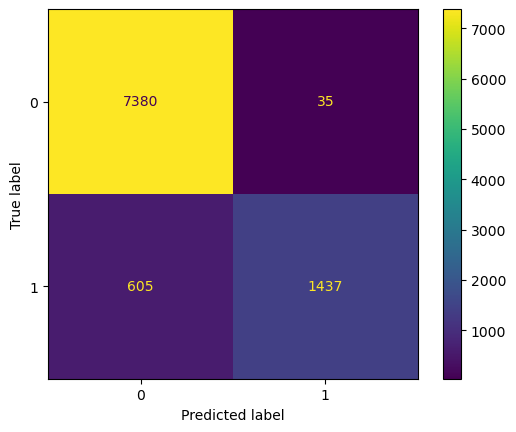

In [50]:
#Create and plot confusion matrix
confusionMatrix_decision_Tree         = confusion_matrix(y_test, decision_Tree_Pred)
confusionMatrix_display_decision_Tree = ConfusionMatrixDisplay(confusion_matrix = confusionMatrix_decision_Tree, display_labels = ['0','1'])
confusionMatrix_display_decision_Tree.plot()
plt.show()

##### Accuracy on the Training Set

In [53]:
train_accuracy_decision_Tree = decision_Tree_Cls.score(X_train_processed, y_train)
round(train_accuracy_decision_Tree, 2)

0.94

##### Accuracy on the Testing set

In [54]:
test_accuracy_decision_Tree = decision_Tree_Cls.score(X_test_processed, y_test) 
round(test_accuracy_decision_Tree, 2)

0.93

#### 2. Logistic Regression

##### Model Fitted

In [55]:
logistic_Regression = LogisticRegression(random_state=42)
logistic_Regression.fit(X_train_processed,y_train)
logisticRegression_Pred = logistic_Regression.predict(X_test_processed)

##### Classfication Report

In [56]:
print(classification_report(y_test,logisticRegression_Pred))

              precision    recall  f1-score   support

           0       0.87      0.95      0.91      7415
           1       0.74      0.50      0.60      2042

    accuracy                           0.85      9457
   macro avg       0.81      0.73      0.75      9457
weighted avg       0.84      0.85      0.84      9457



##### F1 Score

In [59]:
f1_logisticRegression = f1_score(y_test, logisticRegression_Pred, average='weighted')
print('F1-score average is: %.3f' %(f1_logisticRegression))

F1-score average is: 0.843


##### Recall Score

In [58]:
recall_logisticRegression = recall_score(y_test, logisticRegression_Pred, pos_label=1, average='binary')
print('Recall score (class 1) is: %.3f' %(recall_logisticRegression))

Recall score (class 1) is: 0.504


##### Confusion Matrix

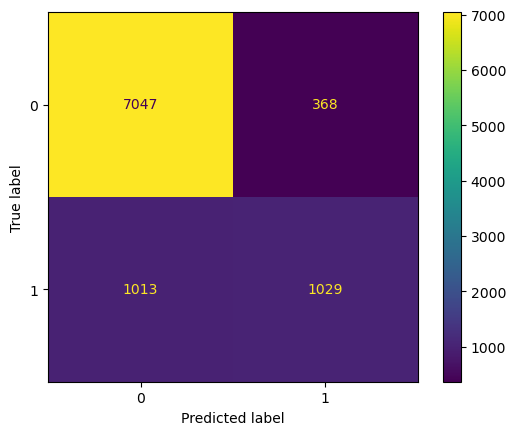

In [60]:
#Create and plot confusion matrix
confusionMatrix_logisticRegression = confusion_matrix(y_test, logisticRegression_Pred)
confusionMatrixDisplay_logisticRegression = ConfusionMatrixDisplay(confusion_matrix = confusionMatrix_logisticRegression, display_labels=['0','1'])
confusionMatrixDisplay_logisticRegression.plot()
plt.show()

##### Accuracy on the Training Set

In [63]:
train_accuracy_logistic_Regression = logistic_Regression.score(X_train_processed, y_train)
round(train_accuracy_logistic_Regression, 3)

0.854

##### Accuracy on the Testing Set

In [64]:
test_accuracy_logistic_Regression = logistic_Regression.score(X_test_processed, y_test) 
round(test_accuracy_logistic_Regression, 3)

0.854

#### 3. KNeighborsClassifier

##### Model Fitted

In [65]:
knn = KNeighborsClassifier(n_neighbors = 8)
knn.fit(X_train_processed,y_train)
knn_prediction = knn.predict(X_test_processed)

##### Classification Report

In [66]:
print(classification_report(y_test, knn_prediction))

              precision    recall  f1-score   support

           0       0.88      0.99      0.93      7415
           1       0.91      0.49      0.64      2042

    accuracy                           0.88      9457
   macro avg       0.89      0.74      0.78      9457
weighted avg       0.88      0.88      0.86      9457



##### F1 Score

In [67]:
f1_knn =f1_score(y_test, knn_prediction, average='weighted')
print('F1-score average is: %.3f' %(f1_knn))

F1-score average is: 0.865


##### Recall Score

In [68]:
recall_knn = recall_score(y_test, knn_prediction, pos_label=1, average='binary')
print('Recall score (class 1) is: %.3f' %(recall_knn))

Recall score (class 1) is: 0.492


##### Confusion Matrix

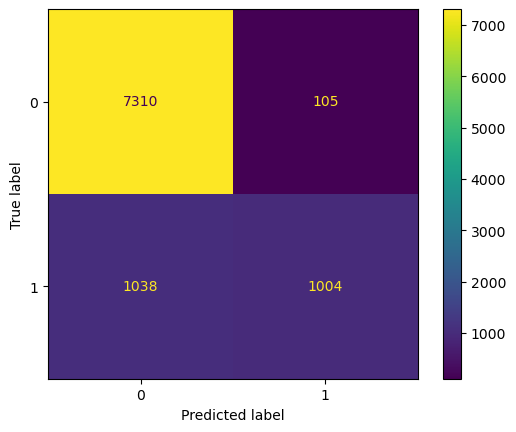

In [69]:
#Create and plot confusion matrix
knn_confusionMatrix = confusion_matrix(y_test, knn_prediction)
knn_confusionMatrix_Dispaly = ConfusionMatrixDisplay(confusion_matrix = knn_confusionMatrix, display_labels=['0','1'])
knn_confusionMatrix_Dispaly.plot()
plt.show()

##### Accuracy on the Training Set

In [70]:
KNN_trainAccuracy = knn.score(X_train_processed, y_train)
round(KNN_trainAccuracy, 2)

0.89

##### Accuracy on the Testing Set

In [72]:
KNN_testAccuracy = knn.score(X_test_processed, y_test)
round(KNN_testAccuracy, 2)

0.88

#### 4. Random Forest Classifier

##### Model Fitted

In [73]:
randomForest_CLS = RandomForestClassifier(max_depth=8, 
                                          class_weight='balanced_subsample', 
                                          random_state=42)

randomForest_CLS.fit(X_train_processed,y_train)

randomForest_pred = randomForest_CLS.predict(X_test_processed)

##### Classification Report

In [74]:
print(classification_report(y_test, randomForest_pred))

              precision    recall  f1-score   support

           0       0.93      0.95      0.94      7415
           1       0.79      0.76      0.78      2042

    accuracy                           0.91      9457
   macro avg       0.86      0.85      0.86      9457
weighted avg       0.90      0.91      0.90      9457



##### F1 Score

In [75]:
f1_randomForest = f1_score(y_test, 
                           randomForest_pred, 
                           average='weighted')

print('F1-score average is: %.3f' %(f1_randomForest))

F1-score average is: 0.905


##### Recall Score

In [76]:
recall_randomForest = recall_score(y_test, 
                         randomForest_pred,
                         pos_label=1,
                         average='binary')

print('Recall score (class 1) is: %.3f' %(recall_randomForest))

Recall score (class 1) is: 0.760


##### Confusion Matrix

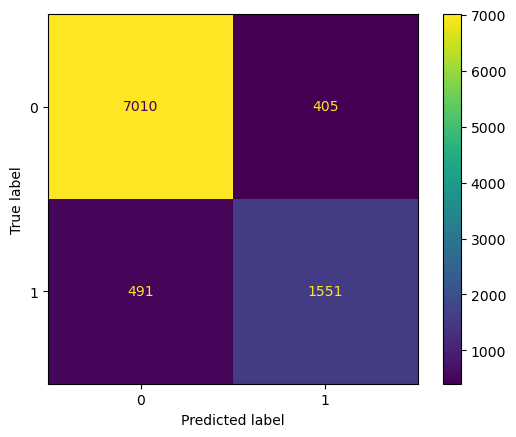

In [78]:
randomForest_ConfusionMatrix = confusion_matrix(y_test, randomForest_pred)

ConfusionMatrixDisplay_rf = ConfusionMatrixDisplay(confusion_matrix = randomForest_ConfusionMatrix,
                                       display_labels=['0','1'])

ConfusionMatrixDisplay_rf.plot()
plt.show()

##### Accuracy on the Training Set

In [79]:
randomForest_trainAccuracy = randomForest_CLS.score(X_train_processed, y_train)
round(randomForest_trainAccuracy, 2)

0.91

##### Accuracy on the Testing Set

In [80]:
randomForest_testAccuracy = randomForest_CLS.score(X_test_processed, y_test) 
round(randomForest_testAccuracy, 2)

0.91

#### 5. XGBoost Classifier

##### Model FItted

In [82]:
XGB_CLS = XGBClassifier(random_state=42)
XGB_CLS.fit(X_train_processed, y_train)
xgb_pred= XGB_CLS.predict(X_test_processed)

##### Classification Report

In [83]:
print(classification_report(y_test, xgb_pred))

              precision    recall  f1-score   support

           0       0.93      0.99      0.96      7415
           1       0.96      0.74      0.83      2042

    accuracy                           0.94      9457
   macro avg       0.95      0.87      0.90      9457
weighted avg       0.94      0.94      0.93      9457



##### F1 Score

In [84]:
f1_XGB = f1_score(y_test, 
                  xgb_pred,
                  average='weighted')

print('F1-score average is: %.3f' %(f1_XGB))

F1-score average is: 0.934


##### Recall Score

In [85]:
recall_XGB = recall_score(y_test,
                          xgb_pred,
                          pos_label=1,
                          average='binary')

print('Recall score (class 1) is: %.3f' %(recall_XGB))

Recall score (class 1) is: 0.739


##### Confusion Matrix

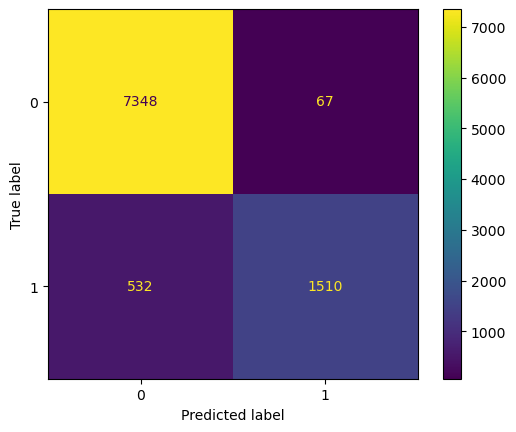

In [86]:
#Create and plot confusion matrix
XGB_confusionMatrix = confusion_matrix(y_test, xgb_pred)
XGB_confusionMatrixDisplay = ConfusionMatrixDisplay(confusion_matrix = XGB_confusionMatrix,
                                        display_labels=['0','1'])
XGB_confusionMatrixDisplay.plot()
plt.show()

##### Accuracy on the Training Set

In [87]:
XGB_trainAccuracy = XGB_CLS.score(X_train_processed, y_train)
round(XGB_trainAccuracy, 2)

0.96

##### Accuracy on the Testing Set

In [88]:
XGB_testAccuracy = XGB_CLS.score(X_test_processed, y_test) 
round(XGB_testAccuracy, 2)

0.94

#### 6. CATBoost Classifier

##### Model Fitted

In [89]:
CBT_CLS = CatBoostClassifier(verbose=0, random_state=42)
CBT_CLS.fit(X_train_processed, y_train)
CBT_pred = CBT_CLS.predict(X_test_processed)

##### Classification Report

In [90]:
print(classification_report(y_test, CBT_pred))

              precision    recall  f1-score   support

           0       0.93      1.00      0.96      7415
           1       0.98      0.73      0.83      2042

    accuracy                           0.94      9457
   macro avg       0.95      0.86      0.90      9457
weighted avg       0.94      0.94      0.93      9457



##### F1 Score

In [91]:
f1_CBT = f1_score(y_test, 
                   CBT_pred,
                   average='weighted')
print('F1-score average is: %.3f' %(f1_CBT))

F1-score average is: 0.934


##### Recall Score

In [92]:
recall_CBT = recall_score(y_test,
                          CBT_pred,
                          pos_label=1,
                          average='binary')

print('Recall score (class 1) is: %.3f' %(recall_CBT))

Recall score (class 1) is: 0.727


##### Confusion Matrix

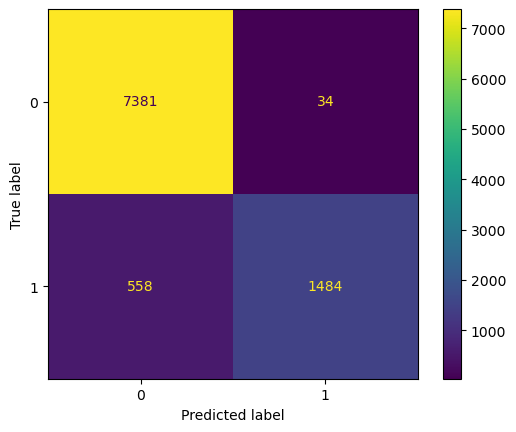

In [93]:
CBT_confusionMatrix = confusion_matrix(y_test, CBT_pred)

CBT_confusionMatrixDisplay = ConfusionMatrixDisplay(confusion_matrix = CBT_confusionMatrix,
                                         display_labels=['0','1'])
CBT_confusionMatrixDisplay.plot()
plt.show()

##### Accuracy on the Training Set

In [94]:
CBT_trainAccuracy = CBT_CLS.score(X_train_processed, y_train)
round(CBT_trainAccuracy, 2)

0.95

##### Accuracy on the Testing Set

In [95]:
CBT_testAccuracy = CBT_CLS.score(X_test_processed, y_test) 
round(CBT_testAccuracy, 2)

0.94

### Model Comparison's

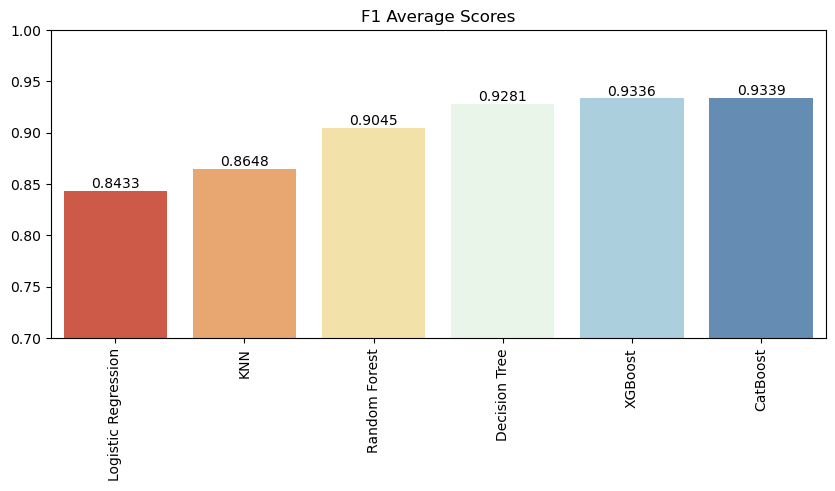

In [101]:
sns.set_palette('RdYlBu')
plt.figure(figsize = (10,4))

classifier = ['Decision Tree', 
              'Logistic Regression', 
              'KNN',
              'Random Forest',
              'XGBoost',
              'CatBoost']

f1_scores = [round(f1_decision_Tree, 4), 
      round(f1_logisticRegression, 4),
      round(f1_knn, 4),
      round(f1_randomForest, 4),
      round(f1_XGB, 4),
      round(f1_CBT, 4)]

# Plot Bar chart
classifier_F1Scores = pd.DataFrame({"Classifier": classifier,
                  "F1_score": f1_scores})
# Plot Bar chart
ax = sns.barplot(x = classifier, y = f1_scores, order = classifier_F1Scores.sort_values('F1_score').Classifier)

plt.tick_params(axis='x', labelrotation=90)
plt.title('F1 Average Scores')
plt.ylim(0.7, 1.0)

ax.bar_label(ax.containers[0])

# Display graph
plt.show()

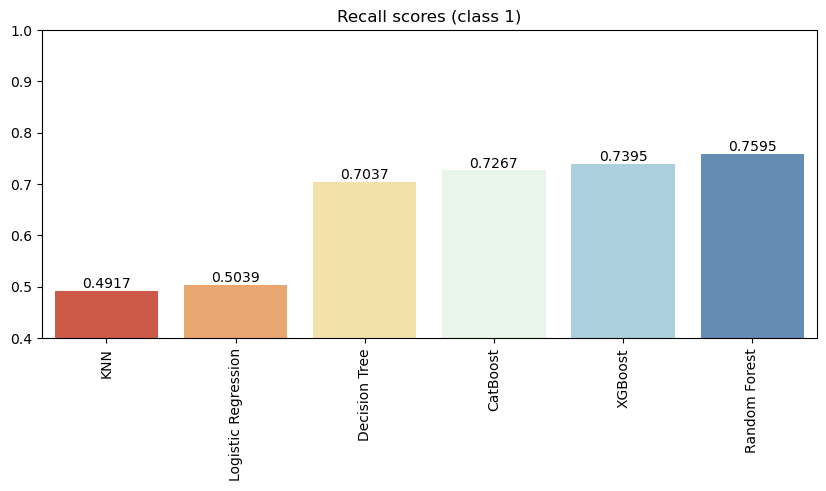

In [103]:
sns.set_palette('RdYlBu')
plt.figure(figsize = (10,4))

recall = [round(recall_decision_Tree, 4), 
          round(recall_logisticRegression, 4), 
          round(recall_knn, 4), 
          round(recall_randomForest, 4),
          round(recall_XGB, 4),
          round(recall_CBT, 4)]

# Plot Bar chart
recall_scores = pd.DataFrame({"Classifier": classifier,
                  "Recall Score": recall})
# Plot Bar chart
ax = sns.barplot(x = classifier,
                 y = recall,
                 order = recall_scores.sort_values('Recall Score').Classifier)

plt.tick_params(axis='x', labelrotation=90)
plt.title('Recall scores (class 1)')
plt.ylim(0.4, 1.0)

ax.bar_label(ax.containers[0])

# Display graph
plt.show()

### Models Optimization

We performed hyperparameter tuning by conducting a Randomized Search on the three best models trained: Random Forest, XGBoost, and CatBoost. Our optimization is centered on recall scoring, as our primary objective is to predict default customers with minimal false negatives. Precisely identifying the maximum number of customers with a high default risk is crucial in our scenario, and precision holds less significance than recall.

#### 1. Optimizing Random Forest Classifier with Randomized Hyperparameter Search

In [104]:
# Define the hyperparameter search space for Random Forest
randomForest_Grid = {
    'min_samples_split': [2, 5, 10, 15, 20, 25],  # Minimum samples to split a node
    'min_samples_leaf': [2, 4, 6, 8, 10],  # Minimum samples required in a leaf node
    'max_depth': [4, 5, 6, 7, 8, 9, 10, 15, 20],  # Maximum tree depth
    'n_estimators': [400, 600, 800, 1000, 1500, 3000, 5000, 10000, 15000],  # Number of trees
    'max_features': ['sqrt'],  # Maximum number of features considered for each split
    'bootstrap': [True, False],  # Sampling method for training each tree
    'class_weight': ['balanced', 'balanced_subsample']  # Weighting scheme for classes
}

iterations, cv = 10, 5

randomForest_GridSearch = RandomizedSearchCV(estimator=RandomForestClassifier(), 
                                param_distributions = randomForest_Grid, 
                                n_iter = iterations, 
                                scoring='recall', 
                                cv = cv, 
                                verbose=0, 
                                random_state=42, 
                                n_jobs = -1)

### Fit the random search model
randomForest_GridSearch.fit(X_train_processed, y_train)

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'class_weight': ['balanced',
                                                         'balanced_subsample'],
                                        'max_depth': [4, 5, 6, 7, 8, 9, 10, 15,
                                                      20],
                                        'max_features': ['sqrt'],
                                        'min_samples_leaf': [2, 4, 6, 8, 10],
                                        'min_samples_split': [2, 5, 10, 15, 20,
                                                              25],
                                        'n_estimators': [400, 600, 800, 1000,
                                                         1500, 3000, 5000,
                                                         10000, 15000]},
                   random_state=42, scoring='recall')

##### Best Random Forest Model Results

In [105]:
print(f'Best Random Forest Score: {randomForest_GridSearch.best_score_:.3f}')
print(f'Best Hyperparameters: {randomForest_GridSearch.best_params_}')

Best Random Forest Score: 0.763
Best Hyperparameters: {'n_estimators': 10000, 'min_samples_split': 5, 'min_samples_leaf': 8, 'max_features': 'sqrt', 'max_depth': 6, 'class_weight': 'balanced', 'bootstrap': False}


##### Model Fitted

In [106]:
optimal_randomForest            = randomForest_GridSearch.best_estimator_
optimal_randomForest_Prediction = optimal_randomForest.predict(X_test_processed)

##### Classification Report

In [107]:
print(classification_report(y_test, 
                            optimal_randomForest_Prediction))

              precision    recall  f1-score   support

           0       0.94      0.92      0.93      7415
           1       0.74      0.77      0.75      2042

    accuracy                           0.89      9457
   macro avg       0.84      0.85      0.84      9457
weighted avg       0.89      0.89      0.89      9457



##### F1 Score

In [108]:
optimal_randomForest_F1 = f1_score(y_test, 
                                   optimal_randomForest_Prediction,
                                   average='weighted')

print('F1-score average is: %.3f' %(optimal_randomForest_F1))

F1-score average is: 0.892


##### Recall Score

In [109]:
optimal_randomForest_Recall = recall_score(y_test,
                                           optimal_randomForest_Prediction,
                                           pos_label=1,
                                           average='binary')

print('Recall score (class 1) is: %.3f' %(optimal_randomForest_Recall))

Recall score (class 1) is: 0.770


##### Confusion Matrix

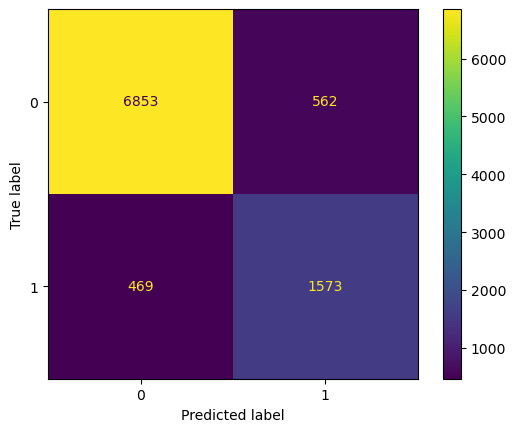

In [110]:
#Create and plot confusion matrix
optimal_randomForest_ConfusionMatrix = confusion_matrix(y_test,
                                                        optimal_randomForest_Prediction)

confusionMatrixDisplay_ORF = ConfusionMatrixDisplay(confusion_matrix = optimal_randomForest_ConfusionMatrix,
                                            display_labels=['0','1'])
confusionMatrixDisplay_ORF.plot()
plt.show()

##### Accuracy on the Training Set

In [111]:
trainAccuracy_ORF = optimal_randomForest.score(X_train_processed,
                                               y_train)
print(round(trainAccuracy_ORF, 2))

0.89


##### Accuracy on the Testing Set

In [113]:
testAccuracy_ORF = optimal_randomForest.score(X_test_processed,
                                              y_test) 
print(round(testAccuracy_ORF, 2))

0.89


##### Precision-Recall Curve

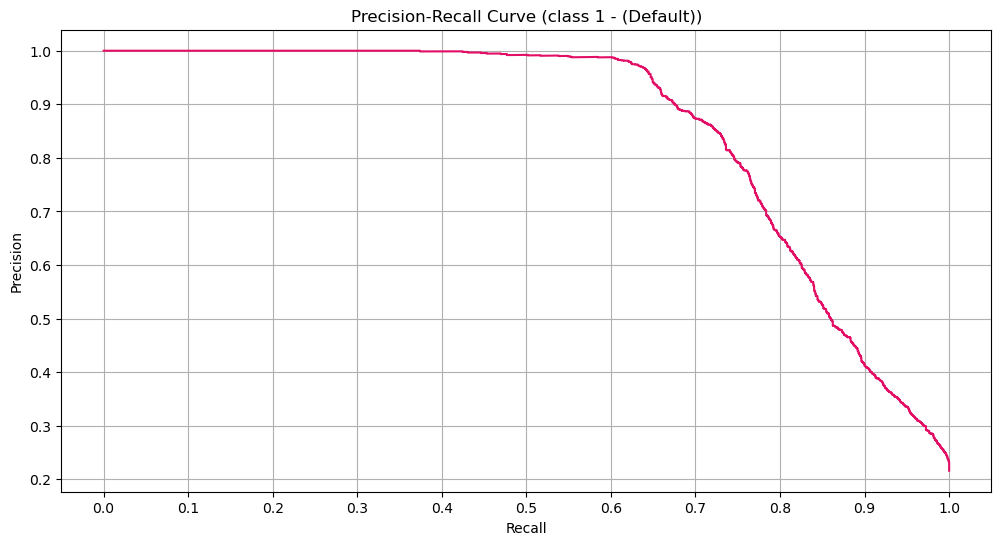

In [115]:
yScore_ORF = optimal_randomForest.predict_proba(X_test_processed)[:, 1]

#calculate precision and recall
precision, recall, thresholds = precision_recall_curve(y_test, yScore_ORF)

sns.set_palette('tab10')
plt.figure(figsize = (12,6))

#create precision recall curve
plt.plot(recall, precision, color='#E30E65')

#add axis labels to plot
plt.title('Precision-Recall Curve for Optimized Random Forest Classifier')
plt.ylabel('Precision')
plt.xlabel('Recall')


# Create an array of x-ticks from 0 to 1 with a step of 0.1
x_ticks = np.arange(0, 1.1, 0.1)

# Set the x-ticks and enable the grid lines
plt.xticks(x_ticks)
plt.grid()

#add axis labels to plot
plt.title('Precision-Recall Curve (class 1 - (Default))')
plt.ylabel('Precision')
plt.xlabel('Recall')

#display plot
plt.show()

#### 2. Optimizing XGBoost with Randomized Hyperparameter Search

In [116]:
# Define the hyperparameter search space for XGBoost
xgb_Grid = {
    "learning_rate": [0.005, 0.01, 0.02, 0.03, 0.05],  # Learning rate
    "max_depth": [2, 3, 4, 5, 6, 7, 8, 9, 10],  # Maximum tree depth
    "gamma": [0, 0.001, 0.01, 0.1, 0.2, 0.3, 1, 5],  # Minimum loss reduction for split
    "min_child_weight": [1, 2, 3, 4],  # Minimum sum of weights required in a child
    "colsample_bytree": [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],  # Subsample ratio of columns
    "reg_alpha": [0, 1e-2, 0.1, 1],  # L1 regularization term
    "reg_lambda": [0, 1e-2, 0.1, 1],  # L2 regularization term
    "scale_pos_weight": [1, 2, 3, 4, 5]  # Weight for imbalanced datasets
}

iterations, cv, scoring, jobs, verbose, random_state = 50, 5, 'recall', -1, 0, 43

# Define random search
xgb_SearchGrid = RandomizedSearchCV(estimator = XGBClassifier(), 
                           param_distributions   = xgb_Grid, 
                           n_iter       = iterations,
                           scoring      = scoring,  
                           n_jobs       = jobs, 
                           cv           = cv, 
                           verbose      = verbose, 
                           random_state = random_state)
# Fit grid search
xgb_SearchGrid.fit(X_train_processed,
                   y_train)

RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, gpu_id=None,
                                           grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate...
                   n_iter=50, n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.5, 0.6, 0.7, 0.8,
                                                             0.9, 1.0],
                                        'gamma': [0, 0.001, 0.01, 0.1, 0.2, 0.3,
                                                  1, 5],
                                        'learning_rate': [0.005, 0.01, 0.02,
                                                          0.03, 0.05],
                                        'max_depth': [2, 3, 4, 5, 6, 7, 8, 9,
                                                      10],
                                        'min_child_weight': [1, 2, 3, 4],
                                        'reg_alpha': [0, 0.01, 0.1, 1],
                                        'reg_lambda': [0, 0.01, 0.1, 1],
                                        'scale_pos_weight': [1, 2, 3, 4, 5]},
                   random_state=43, scoring='recall')

##### Best XGB Model Results

In [117]:
print(f'Best XGB Score: {xgb_SearchGrid.best_score_:.3f}')
print(f'Best Hyperparameters: {xgb_SearchGrid.best_params_}')

Best XGB Score: 0.838
Best Hyperparameters: {'scale_pos_weight': 5, 'reg_lambda': 0.1, 'reg_alpha': 1, 'min_child_weight': 4, 'max_depth': 6, 'learning_rate': 0.005, 'gamma': 0.1, 'colsample_bytree': 0.5}


##### Model Fitted

In [118]:
optimal_xgb            = xgb_SearchGrid.best_estimator_
optimal_xgb_Prediction = optimal_xgb.predict(X_test_processed)

##### Classification Report

In [119]:
print(classification_report(y_test,
                            optimal_xgb_Prediction))

              precision    recall  f1-score   support

           0       0.95      0.82      0.88      7415
           1       0.57      0.84      0.68      2042

    accuracy                           0.83      9457
   macro avg       0.76      0.83      0.78      9457
weighted avg       0.87      0.83      0.84      9457



##### F1 Score

In [120]:
optimal_xgb_F1 = f1_score(y_test,
                          optimal_xgb_Prediction,
                          average='weighted')

print('F1-score average is: %.3f' %(optimal_xgb_F1))

F1-score average is: 0.837


##### Recall Score

In [121]:
optimal_xgb_Recall = recall_score(y_test,
                                  optimal_xgb_Prediction,
                                  pos_label=1,
                                  average='binary')

print('Recall score (class 1) is: %.3f' %(optimal_xgb_Recall))

Recall score (class 1) is: 0.841


##### Confusion Matrix

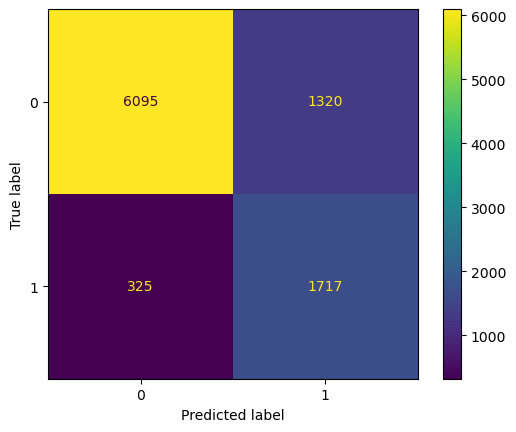

In [122]:
#Create and plot confusion matrix
optimal_xgb_ConfusionMatrix = confusion_matrix(y_test,
                                               optimal_xgb_Prediction)

ConfusionMatrixDisplay      = ConfusionMatrixDisplay(confusion_matrix =optimal_xgb_ConfusionMatrix,
                                             display_labels=['0','1'])
ConfusionMatrixDisplay.plot()
plt.show()

##### Accuracy on the Training Set

In [123]:
optimalXGB_TrainAccuracy = optimal_xgb.score(X_train_processed, y_train)
print(round(optimalXGB_TrainAccuracy, 2))

0.83


##### Accuracy on the Testing Set

In [124]:
optimalXGB_testAccuracy = optimal_xgb.score(X_test_processed, y_test) 
print(round(optimalXGB_testAccuracy, 2))

0.83


##### Precision - Recall Curve 

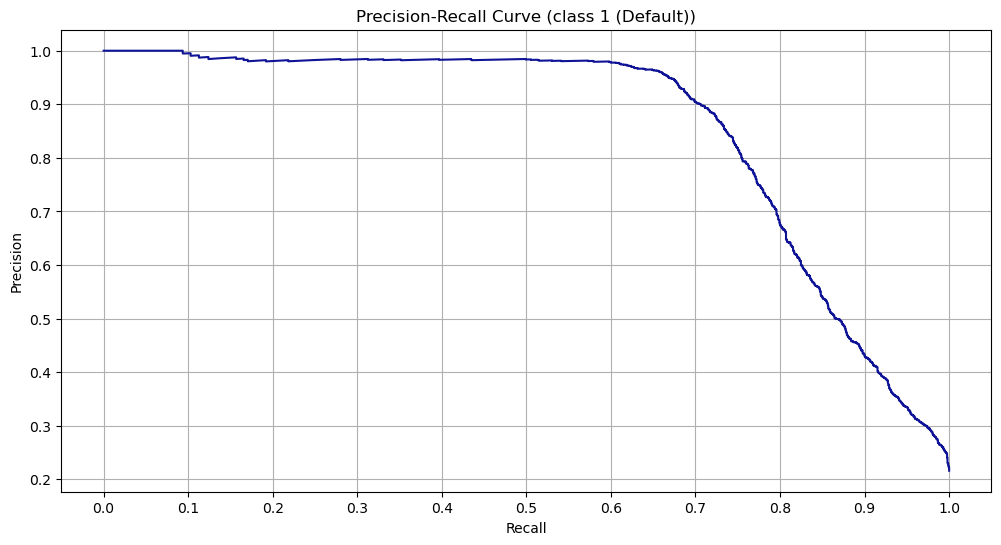

In [125]:
yScore_OXGB = optimal_xgb.predict_proba(X_test_processed)[:, 1]

#calculate precision and recall
precision, recall, thresholds = precision_recall_curve(y_test, yScore_OXGB)

sns.set_palette('tab10')
plt.figure(figsize = (12,6))

#create precision recall curve
plt.plot(recall, precision, color='#0F1396')

#add axis labels to plot
plt.title('Precision-Recall Curve for optimized XGBoost Classifier')
plt.ylabel('Precision')
plt.xlabel('Recall')

# Create an array of x-ticks from 0 to 1 with a step of 0.1
x_ticks = np.arange(0, 1.1, 0.1)

# Set the x-ticks and enable the grid lines
plt.xticks(x_ticks)
plt.grid()

#add axis labels to plot
plt.title('Precision-Recall Curve (class 1 (Default))')
plt.ylabel('Precision')
plt.xlabel('Recall')

#display plot
plt.show()

#### 3. Optimizing CATBoost with Randomized Hyperparameter Search

In [126]:
# Define the hyperparameter search space for CatBoost
catBoost_Grid = {
    'iterations': [100, 200, 500],  # Maximum number of trees
    'learning_rate': [0.001, 0.005, 0.01],  # Learning rate
    'depth': [2, 3, 4, 5, 6, 7, 8, 9, 10],  # Depth of tree
    'subsample': [0.1, 0.5, 0.8],  # Subsample fraction
    'colsample_bylevel': [0.05, 0.1, 0.5],  # Feature subsample fraction per level
    'l2_leaf_reg': [1, 2, 3, 4, 5],  # L2 regularization coefficient
    'min_data_in_leaf': [1, 5, 10, 50, 100, 150],  # Minimum samples per leaf
    'scale_pos_weight': [1, 2, 3, 4]  # Weight for imbalanced datasets
}

iterations, cv, scoring, verbose, jobs, random_state = 10, 5, 'recall', False, -1, 42

catBoost_Search = RandomizedSearchCV(estimator = CatBoostClassifier(verbose=False), 
                                param_distributions = catBoost_Grid, 
                                n_iter       = iterations, 
                                scoring      = scoring, 
                                cv           = cv, 
                                verbose      = verbose, 
                                random_state = random_state, 
                                n_jobs       = jobs);

# Fit the catBoost model
catBoost_Search.fit(X_train_processed, y_train);

##### Best CatBoost Model Result

In [127]:
print(f'Best CatBoost Score: {catBoost_Search.best_score_:.3f}')
print(f'Best Hyperparameters: {catBoost_Search.best_params_}')

Best CatBoost Score: 0.783
Best Hyperparameters: {'subsample': 0.5, 'scale_pos_weight': 4, 'min_data_in_leaf': 5, 'learning_rate': 0.001, 'l2_leaf_reg': 5, 'iterations': 500, 'depth': 9, 'colsample_bylevel': 0.1}


##### Model Fitted

In [128]:
catBoost_Optimal            = catBoost_Search.best_estimator_
catBoost_Optimal_Prediction = catBoost_Optimal.predict(X_test_processed)

##### Classification Report

In [129]:
print(classification_report(y_test, 
                            catBoost_Optimal_Prediction))

              precision    recall  f1-score   support

           0       0.94      0.85      0.90      7415
           1       0.60      0.80      0.69      2042

    accuracy                           0.84      9457
   macro avg       0.77      0.83      0.79      9457
weighted avg       0.87      0.84      0.85      9457



##### F1 Score

In [130]:
catBoost_Optimal_F1 = f1_score(y_test,
                               catBoost_Optimal_Prediction,
                               average='weighted')

print('F1-score average is: %.3f' %(catBoost_Optimal_F1));

F1-score average is: 0.851


##### Recall Score

In [131]:
catBoost_Optimal_Recall = recall_score(y_test,
                                       catBoost_Optimal_Prediction,
                                       pos_label=1,
                                       average='binary')

print('Recall score (class 1) is: %.3f' %(catBoost_Optimal_Recall));

Recall score (class 1) is: 0.802


##### Confusion Matrix

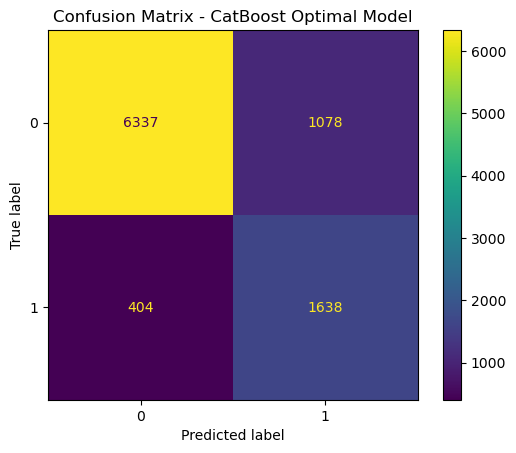

In [138]:
catBoostOptimal_ConfusionMatrix = confusion_matrix(y_test, catBoost_Optimal_Prediction)
confusionMatrixDisplay = ConfusionMatrixDisplay(confusion_matrix=catBoostOptimal_ConfusionMatrix, display_labels=['0', '1'])
confusionMatrixDisplay.plot()
plt.title('Confusion Matrix - CatBoost Optimal Model')
plt.show()

##### Accuracy on the Training Set

In [139]:
catBoostOptimal_trainAccuracy = catBoost_Optimal.score(X_train_processed, y_train)
print(round(catBoostOptimal_trainAccuracy, 2))

0.84


##### Accuracy on the Testing Set

In [140]:
catBoostOptimal_TestAccuracy = catBoost_Optimal.score(X_test_processed, y_test) 
print(round(catBoostOptimal_TestAccuracy, 2))

0.84


##### Precision - Recall Curve

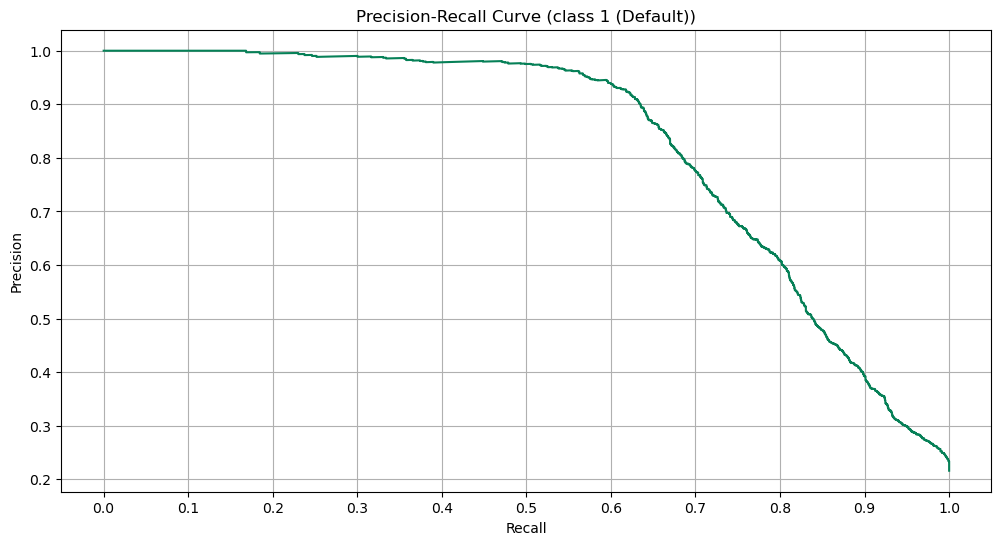

In [142]:
yScore_OCAT = catBoost_Optimal.predict_proba(X_test_processed)[:, 1]

#calculate precision and recall
precision, recall, thresholds = precision_recall_curve(y_test, yScore_OCAT)

sns.set_palette('tab10')
plt.figure(figsize = (12,6))

#create precision recall curve
plt.plot(recall, precision, color='#068057')

#add axis labels to plot
plt.title('Precision-Recall Curve for optimized Cat Boost Classifier')
plt.ylabel('Precision')
plt.xlabel('Recall')

# Create an array of x-ticks from 0 to 1 with a step of 0.1
x_ticks = np.arange(0, 1.1, 0.1)

# Set the x-ticks and enable the grid lines
plt.xticks(x_ticks)
plt.grid()

#add axis labels to plot
plt.title('Precision-Recall Curve (class 1 (Default))')
plt.ylabel('Precision')
plt.xlabel('Recall')

#display plot
plt.show()

### Tunned Model Comparison

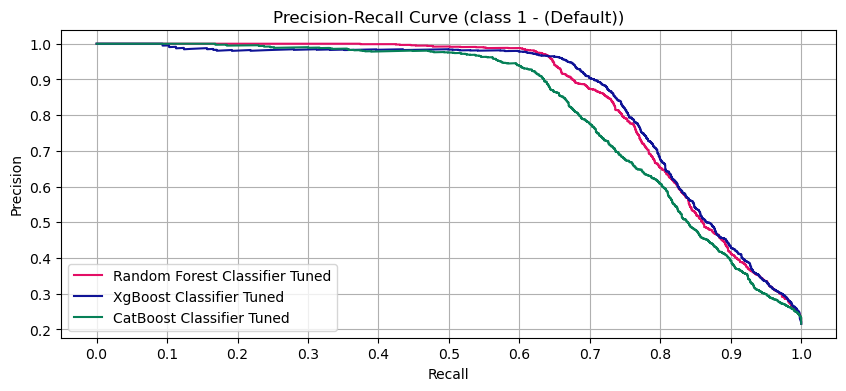

In [143]:
sns.set_palette('tab10')
plt.figure(figsize = (10,4))

#calculate precision and recall for Random Forest Classifier
precision_ORF, recall_ORF, thresholds_ORF = precision_recall_curve(y_test, yScore_ORF)
plt.plot(recall_ORF, precision_ORF, color = '#E30E65', label = 'Random Forest Classifier Tuned')

#calculate precision and recall for XGBoost Classifier
precision_OXGB, recall_OXGB, thresholds_OXGB = precision_recall_curve(y_test, yScore_OXGB)
plt.plot(recall_OXGB, precision_OXGB, color='#0F1396', label='XgBoost Classifier Tuned')

#calculate precision and recall for CatBoost Classifier
precision_OCAT, recall_OCAT, thresholds_OCAT = precision_recall_curve(y_test, yScore_OCAT)
plt.plot(recall_OCAT, precision_OCAT, color = '#068057', label = 'CatBoost Classifier Tuned')

#add axis labels to plot
plt.title('Precision-Recall Curve (class 1 - (Default))')
plt.ylabel('Precision')
plt.xlabel('Recall')

# Create an array of x-ticks from 0 to 1 with a step of 0.1
x_ticks = np.arange(0, 1.1, 0.1)

# Set the x-ticks and enable the grid lines
plt.xticks(x_ticks)
plt.grid()

plt.legend()

#display plot
plt.show()

After analyzing the precision-recall curves of the three tuned ensemble models, we have determined that XGBoost is the clear winner with a higher Area Under the Curve.


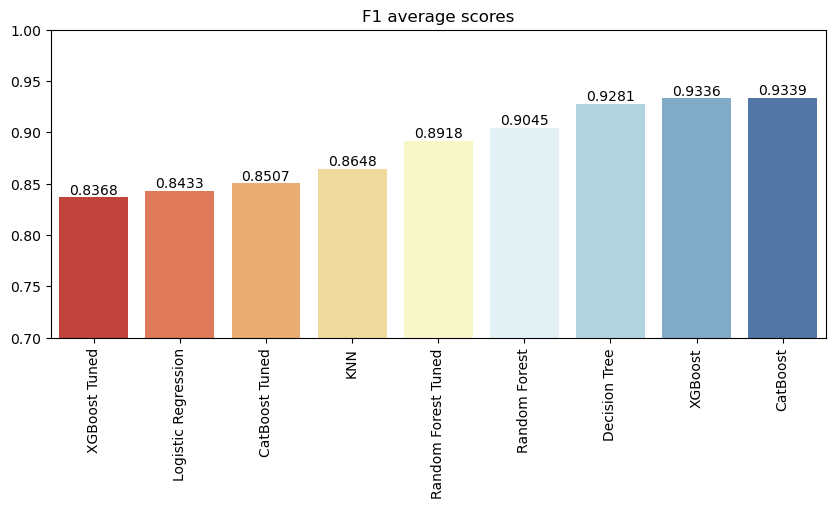

In [146]:
plt.figure(figsize = (10,4))

classifier = ['Decision Tree',
              'Logistic Regression',
              'KNN',
              'Random Forest',
              'XGBoost',
              'CatBoost', 
              'Random Forest Tuned',
              'XGBoost Tuned',
              'CatBoost Tuned']

f1_scores = [round(f1_decision_Tree, 4), 
             round(f1_logisticRegression, 4),
             round(f1_knn, 4),
             round(f1_randomForest, 4),
             round(f1_XGB, 4),
             round(f1_CBT, 4),
             round(optimal_randomForest_F1, 4),
             round(optimal_xgb_F1, 4),
             round(catBoost_Optimal_F1, 4)]


# Plot Bar chart
df = pd.DataFrame({"Classifier": classifier,
                  "F1_score": f1_scores})
# Plot Bar chart
ax = sns.barplot(x = classifier,
                 y = f1_scores, 
                 order = df.sort_values('F1_score').Classifier, palette='RdYlBu')

plt.tick_params(axis='x', labelrotation=90)
plt.title('F1 average scores')
plt.ylim(0.7, 1.0)

ax.bar_label(ax.containers[0])

# Display graph
plt.show()

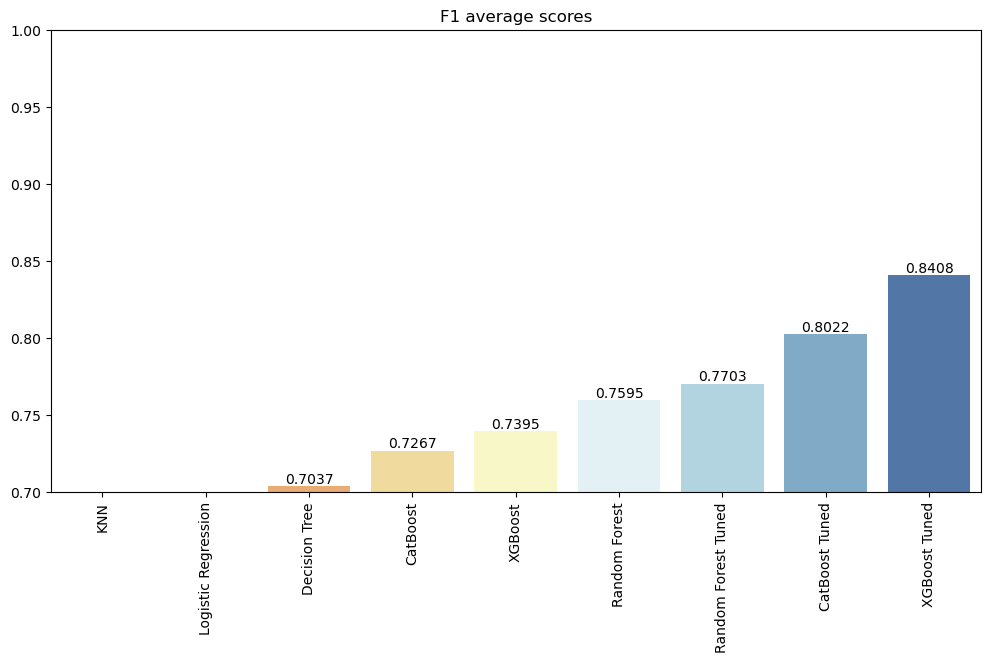

In [149]:
plt.figure(figsize = (12,6))

recall_scores = [round(recall_decision_Tree, 4), 
             round(recall_logisticRegression, 4), 
             round(recall_knn, 4), 
             round(recall_randomForest, 4),
             round(recall_XGB, 4),
             round(recall_CBT, 4),
             round(optimal_randomForest_Recall, 4),
             round(optimal_xgb_Recall, 4),
             round(catBoost_Optimal_Recall, 4)]


# Plot Bar chart
df = pd.DataFrame({"Classifier": classifier,
                  "F1_score": recall_scores})
# Plot Bar chart
ax = sns.barplot(x = classifier,
                 y = recall_scores, 
                 order = df.sort_values('F1_score').Classifier, palette='RdYlBu')

plt.tick_params(axis='x', labelrotation=90)
plt.title('F1 average scores')
plt.ylim(0.7, 1.0)

ax.bar_label(ax.containers[0])

# Display graph
plt.show()

Optimized XGBoost model is the clear winner scoring the best recall score on class 1 (82%) and a high f1 number (88%)

### Feature Importance

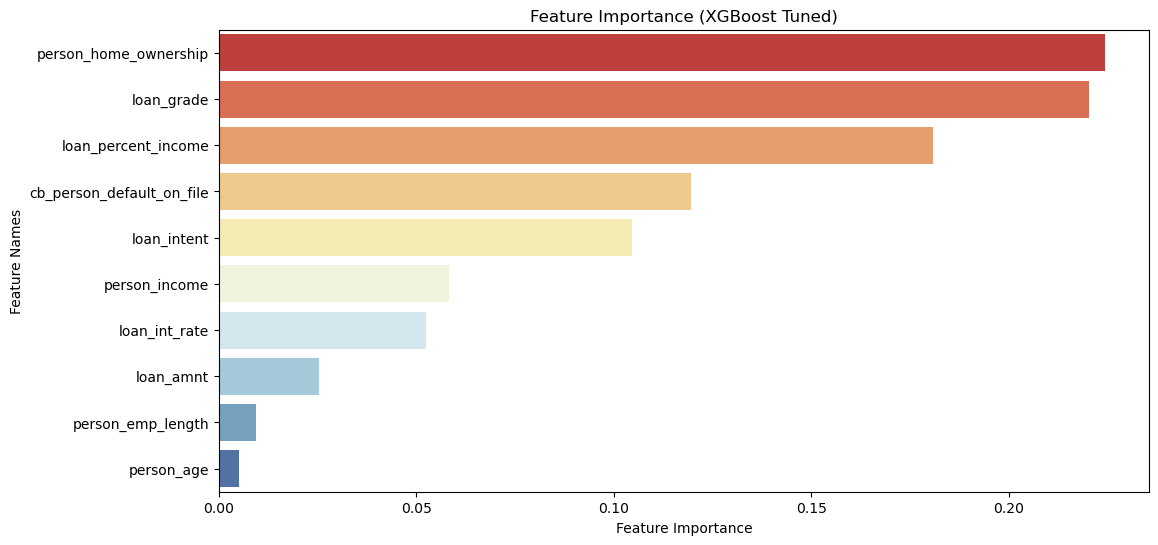

In [151]:
plt.figure(figsize = (12,6))

slice0 = optimal_xgb.feature_importances_[0:6]

slice1 = optimal_xgb.feature_importances_[6:10]
agg1   = slice1.sum()

slice2 = optimal_xgb.feature_importances_[10:16]
agg2   = slice2.sum()

slice3 = optimal_xgb.feature_importances_[16:18]
agg3   = slice3.sum()

slice4 = optimal_xgb.feature_importances_[18:19]

features_aggregated = np.concatenate([slice0, [agg1], [agg2], [agg3], slice4])

optimalXGB_features = {'Feature Names': numerical_Columns + categorical_Columns + ordinal_Column,
        'Feature Importance': features_aggregated }

featureImportances = pd.DataFrame(optimalXGB_features).sort_values('Feature Importance', ascending=False)

sns.barplot(data = featureImportances,
            y = 'Feature Names',
            x = 'Feature Importance',
            orient='h',
            palette='RdYlBu')

plt.title('Feature Importance (XGBoost Tuned)')
plt.show()

The three essential features for XGBoost are 'person_home_ownership,' 'loan_intent,' and 'loan_percent_income.' From this analysis, it is interesting that the two least essential features, person_age and 'person_emp_length,' could be dropped from the dataset given their low impact on the final model.

### Finalize the Pipeline

In [152]:
import joblib

final_pipeline = Pipeline((('preprocessing',column_transformation),('classifier', optimal_xgb)))

#Save Pipeline
joblib.dump(final_pipeline, 'final_pipeline.joblib')

['final_pipeline.joblib']

In [154]:
final_pipeline = joblib.load('final_pipeline.joblib')
final_pipeline

Pipeline(steps=(('preprocessing',
                 ColumnTransformer(transformers=[('numerical',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer()),
                                                                  ('scale',
                                                                   RobustScaler())]),
                                                  ['person_age',
                                                   'person_income',
                                                   'person_emp_length',
                                                   'loan_amnt', 'loan_int_rate',
                                                   'loan_percent_income']),
                                                 ('categorical',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder())]),
                                                  ['person_home_ownership',
                                                   'loan_intent',
                                                   'cb_...
                               feature_types=None, gamma=0.1, gpu_id=None,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None,
                               learning_rate=0.005, max_bin=None,
                               max_cat_threshold=None, max_cat_to_onehot=None,
                               max_delta_step=None, max_depth=6,
                               max_leaves=None, min_child_weight=4, missing=nan,
                               monotone_constraints=None, n_estimators=100,
                               n_jobs=None, num_parallel_tree=None,
                               predictor=None, random_state=None, ...))))

### Conclusion

We have trained nine different ML models on the credit_risk_dataset and compared the f1 number and recall metrics calculated on the test set for each of them. If we look at recall, the best model is undoubtedly the optimized XGBoost, with a weighted average f1 score of 88%, a high recall of 82.5% on class 1, and the best precision-recall curve.

Here are a few suggestions and recommendations for future work:
* Deploy other strategies to cope with unbalanced datasets and compare the results (downsampling, upsampling, synthetic data augmentation, e.g., SMOTE, use of imbalanced learning library, etc.)
* Try more hyperparameters and higher ranges in order to improve the tuning results.
* Try Bayesian optimization as a more efficient way to improve hyperparameter tuning.
* Train more Ensemble methods based on DT (e.g., LightGBM)
* Drop the most minor essential features from the dataset and retrain the model.
* Assign weights to each loan to optimize models that minimize financial loss.